# Clustering t-SNE representations in Figure 1c

This notebook tests clustering methods in https://scikit-learn.org/stable/modules/clustering.html on the data in Scala et al., Figure 1c. The clustering algorithms will be called with default parameters except for number of clusters and random seeds. The number of clusters will be the number of unique labels that were assigned in either Yao et al's or Scala et al.'s article.

If you are unsure about the contents of the original article or datasets associated with Figure 1c, you can refer to `code/about_figure_1c.ipynb`, a summary notebook on matters related to Figure 1c.

 __Datasets:__  <br>
 Figure 1c contains two datasets, <br>
 1. The t-SNE representations for Yao et al.'s transcriptomic data, size (cells, t-SNE features) = (15,511, 2)
 2. The (estimated) t-SNE representations for Scala et al.'s transcriptomic data, size (cells, t-SNE features) = (244, 2)


 __Labels:__<br>
 This notebook tried 2 sets of labels per dataset, <br>
 1. One for broad cell families (Vip/Lamp5/Sncg for Yao et al. and Vip/Lamp5 for Scala et al.)
 2. One for the smaller transcriptomic types (27 unique labels for Yao et al., 19 for Scala et al.)

 __Evaluation:__<br>
Used adjusted mutual information and  Fowlkes-Mallows score

## Table of contents:
* [Broad cell families](#broad)
* [Smaller transcriptomic types](#small)

In [1]:
import pickle
from collections import namedtuple
import numpy as np
import os.path
from sklearn.cluster import *
from preprocess_figdata import preprocess_figure_data
from plot_fig1c import plot_sidebyside
from misc_tools import le_family_names, ami_and_fmscore
from sklearn import preprocessing

import sys
sys.path.append('../')
import rnaseqTools

In [2]:
# load Yao et al.'s dataset for the Vip/Lamp5 cells
m1data = pickle.load(open('../../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))["viplamp"]

# load the study results of Scala et al.
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../../data/processed/rnaseq/m1.pickle', 'rb'))

#load transcriptomic type assignment from Scala et al.
ttypes = pickle.load(open('../../data/processed/rnaseq/ttypes.pickle', 'rb'))
subset = np.isin(ttypes['family'], ['Lamp5', 'Vip']) #mask to get vip/lamp5 cell info from m1

# load t-SNE representations of Yao et al.'s Vip/Lamp5 cells
Z = pickle.load(open('../../data/processed/rnaseq/10x-tsne-viplamp.pickle', 'rb')) 

In [4]:
# function for fitting all the scikit-learn models
def fit_all_sklearn(training_data, true_labels, n_clusters, file_path, random_state):
    """
    This function will fit the training data to all clustering methods in this webpage:
    https://scikit-learn.org/stable/modules/clustering.html
    
    The trained models will be saved in the specified file path.
    arguments n_clusters and random_state are for the clustering methods that have these parameters.
    """
    
    model_dict = {} # a dictionary that will contain all trained models
    
    print("Fitting k-means...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(training_data)
    model_dict["k-means"] = kmeans
    pickle.dump(kmeans, open(file_path + "k-means" + ".pickle", 'wb'))

    print("Fitting affinity propagation...")
    affinity = AffinityPropagation(random_state=random_state).fit(training_data)
    model_dict["affinity"] = affinity
    pickle.dump(affinity, open(file_path + "affinity"+".pickle", 'wb'))

    print("Fitting mean shift...")
    mean_shift = MeanShift().fit(training_data)
    model_dict["mean shift"] = mean_shift
    pickle.dump(mean_shift , open(file_path + "mean_shift" + ".pickle", 'wb'))

    print("Fitting spectral clustering...")
    spectral = SpectralClustering(n_clusters=n_clusters,n_jobs=-1).fit(training_data)
    model_dict["spectral"] = spectral
    pickle.dump(spectral, open(file_path + "spectral" + ".pickle", 'wb'))

    print("Fitting agglomerative clustering...")
    agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(training_data)
    model_dict["agglomerative"] = agglo
    pickle.dump(agglo, open(file_path + "agglomerative" + ".pickle", 'wb'))

    print("Fitting DBSCAN...")
    dbscan = DBSCAN().fit(training_data)
    model_dict["dbscan"] = dbscan
    pickle.dump(dbscan, open(file_path + "dbscan"+".pickle", 'wb'))

    print("Fitting OPTICS...")
    optics = OPTICS().fit(training_data)
    model_dict["optics"] = optics
    pickle.dump(optics, open(file_path + "optics" + ".pickle", 'wb'))

    print("Fitting Birch...")
    birch = Birch(n_clusters=n_clusters).fit(training_data)
    model_dict["birch"] = birch
    pickle.dump(birch, open(file_path + "birch" + ".pickle", 'wb'))
    
    return model_dict

In [5]:
def print_results(training_data, model_dict,true_labels, Z, m1data): 
    """
    This function is for getting and displaying the prediction results.
    
    Z: the t-SNE representations for Yao et al.'s 15,511 cells
    m1data: Yao et al.'s dataset for the subroup "viplamp"
    """
    pred_dict = {} # dictionary to store the predictions
    score_dict = {} # dictionary to store the evaluation scores
    
    # print the adjusted mutual information and Fowlkes-Mallows score
    for  model_name, model in model_dict.items():
        scores={}
        print("-------------------------------"+model_name+"-------------------------------")
        pred = model.labels_
        scores["ami"],  scores["fms"] =  ami_and_fmscore(true_labels, pred) 

        pred_dict[model_name] = pred
        score_dict[model_name] = scores
    
    # plot clustering results with figure 1c
    for  model_name, pred  in pred_dict.items():
        plot_sidebyside(training_data, pred, Z, m1data, title=model_name)
    
    return pred_dict, score_dict

## 1. Broad cell families <a class="anchor" id="broad"></a>

In [6]:
random_state = 0 # setting random state for models 
save = False # setting this to true will train and save the models, else it will load the models saved last time

### Yao et al.'s cells

Yao et al.'s data has 15,511 cells from three broad cell families, Vip, Lamp5, and Sncg. In Figure 1c they are all expressed in 2-dimensional t-SNE representations. The actual colors are for the smaller transcriptomic types, but you can see how they are separated: the reddish purple colors for Vip, pink colors for Lamp5, and deep purple colors for Sncg.

In [7]:
n_clusters = 3 # the number of broad cell families is 3
training_data = Z
file_path = "./models/t-SNE/broad/Yao/" # file path to save or load models

In [8]:
# create broad cell family labels because Yao et al.'s data doesn't come with one
yao_family_names, yao_family_codes = le_family_names(m1data)

Family_labels:
Lamp5: [0]
Sncg: [1]
Vip: [2]


In [9]:
if save == True:
    model_dict_yao = fit_all_sklearn(training_data=Z, true_labels=yao_family_codes, n_clusters=n_clusters, 
                                 file_path=file_path, random_state=random_state)
else:
    model_dict_yao={}
    model_dict_yao["k-means"] = pickle.load(open(file_path + "k-means" + ".pickle", 'rb'))
    model_dict_yao["affinity"] = pickle.load(open(file_path + "affinity"+".pickle", 'rb'))
    model_dict_yao["mean shift"] = pickle.load(open(file_path + "mean_shift" + ".pickle", 'rb'))
    model_dict_yao["spectral"] = pickle.load(open(file_path + "spectral" + ".pickle", 'rb'))
    model_dict_yao["agglo"] = pickle.load(open(file_path + "agglomerative" + ".pickle", 'rb'))
    model_dict_yao["dbscan"] = pickle.load(open(file_path + "dbscan"+".pickle", 'rb'))
    model_dict_yao["optics"] = pickle.load(open(file_path + "optics" + ".pickle", 'rb'))
    model_dict_yao["birch"] = pickle.load(open(file_path + "birch" + ".pickle", 'rb'))

/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KMeans from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator AffinityPropagation from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MeanShift from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SpectralClustering from version 0.23.2 when using version 0.24

-------------------------------k-means-------------------------------
Adjusted Mutual Info: 0.4434050321834581
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.656219406649552
(0: bad, 1: perfect)

-------------------------------affinity-------------------------------
Adjusted Mutual Info: -3.0499166806564216e-16
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.6609807000126934
(0: bad, 1: perfect)

-------------------------------mean shift-------------------------------
Adjusted Mutual Info: 0.4744960189181844
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.7442733871511906
(0: bad, 1: perfect)

-------------------------------spectral-------------------------------
Adjusted Mutual Info: 0.6915390358341484
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.8635060872697874
(0: bad, 1: perfect)

-------------------------------agglo-------------------------------
Adjusted Mutual Info: 0.5371911168931203
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.7300535725580967
(0: bad, 1: perfect)

---

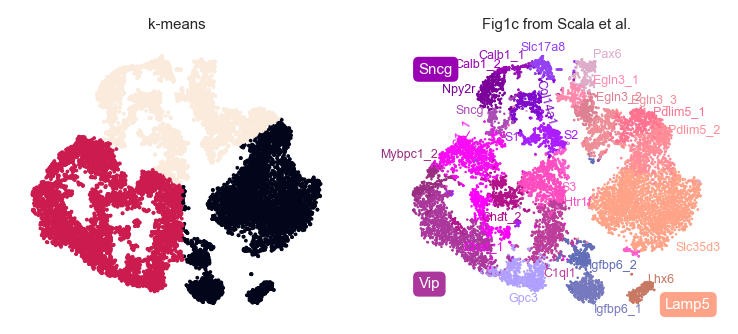

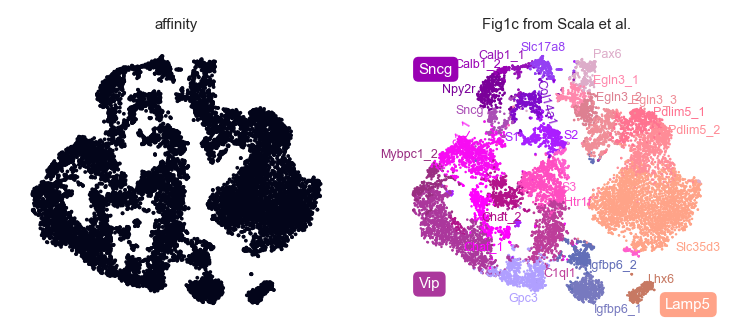

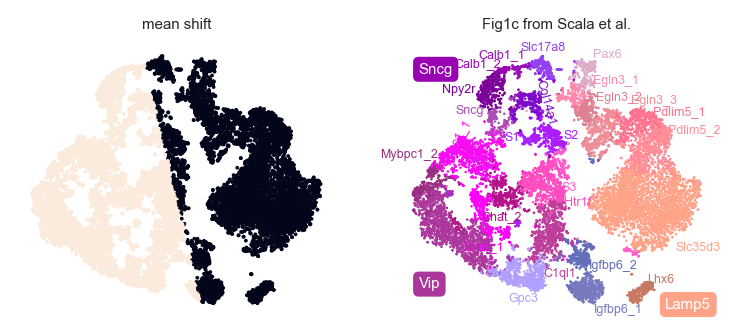

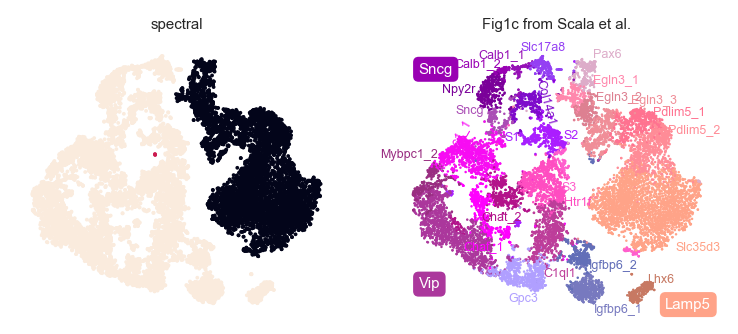

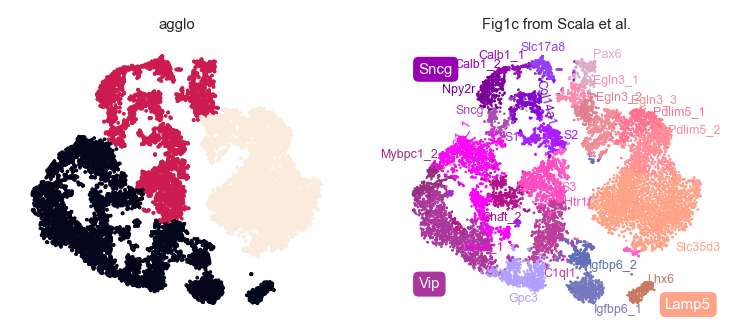

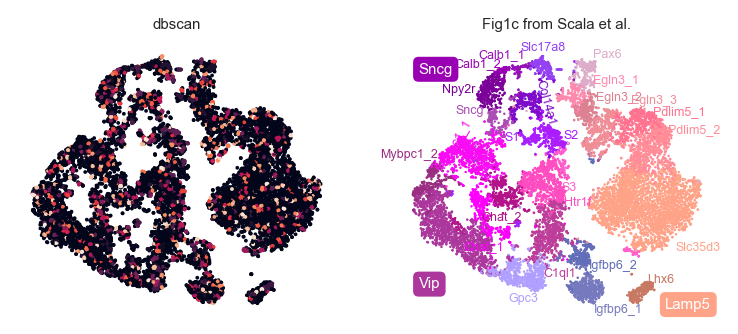

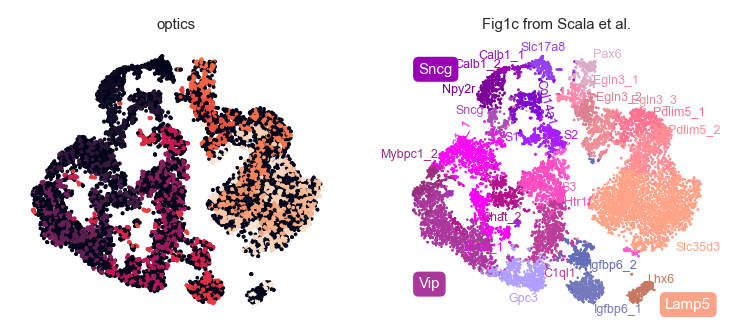

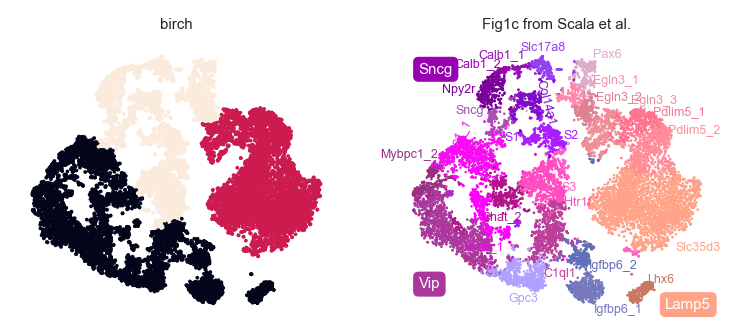

In [10]:
pred_yao, score_yao = print_results(training_data, model_dict_yao,true_labels=yao_family_codes, Z=Z, m1data=m1data)

### Comments

Agglomerative clustering and BIRCH can cluster the cells into something that resembles the true labels, but their scores are lower than the methods that cluster the cells into largely 2 clusters: mean shift and spectral clustering. This may be because there were fewer cells in the Sncg family, and misclassifying the small section of Vip and Lamp5 cells took a net negative effect even if the Sncg cells were correctly classified.

### Scala et al.'s cells

Scala et al.'s data has 244 cells from broad cell families Vip and Lamp5, but not from Sncg. They explained that they did not have enough cells to run analyses on Sncg. They are overlayed on Yao et al.'s cells in Figure 1c in black, where the shapes represent the layers each cell came from. These are not plotted in this notebook because they don't contain relevant information regarding cell types.

In [11]:
# get estimated t-SNE representations
pos = rnaseqTools.map_to_tsne(m1data['counts'], m1data['genes'],
                              m1.exonCounts[subset,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[subset,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

Using a common set of 490 genes.


In [12]:
n_clusters = 2 # the number of broad cell families is 2
training_data = pos
file_path = "./models/t-SNE/broad/Scala/" # file path to save or load models

In [13]:
# get the family codes
le = preprocessing.LabelEncoder()
scala_family_names = ttypes['family'][subset]
scala_family_codes = le.fit_transform(scala_family_names)

print("Family_labels:")
for label in le.classes_:
    print(f"{label}: {le.transform(np.array(label).reshape(-1,))}")

Family_labels:
Lamp5: [0]
Vip: [1]


In [14]:
if save == True:
    model_dict_scala = fit_all_sklearn(training_data=pos, true_labels=scala_family_codes, n_clusters=n_clusters, 
                                 file_path=file_path, random_state=random_state)
else:
    model_dict_scala={}
    model_dict_scala["k-means"] = pickle.load(open(file_path + "k-means" + ".pickle", 'rb'))
    model_dict_scala["affinity"] = pickle.load(open(file_path + "affinity"+".pickle", 'rb'))
    model_dict_scala["mean shift"] = pickle.load(open(file_path + "mean_shift" + ".pickle", 'rb'))
    model_dict_scala["spectral"] = pickle.load(open(file_path + "spectral" + ".pickle", 'rb'))
    model_dict_scala["agglo"] = pickle.load(open(file_path + "agglomerative" + ".pickle", 'rb'))
    model_dict_scala["dbscan"] = pickle.load(open(file_path + "dbscan"+".pickle", 'rb'))
    model_dict_scala["optics"] = pickle.load(open(file_path + "optics" + ".pickle", 'rb'))
    model_dict_scala["birch"] = pickle.load(open(file_path + "birch" + ".pickle", 'rb'))

-------------------------------k-means-------------------------------
Adjusted Mutual Info: 0.8738035557794
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.9694714749093685
(0: bad, 1: perfect)

-------------------------------affinity-------------------------------
Adjusted Mutual Info: 0.4219808839977985
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.4309548570159759
(0: bad, 1: perfect)

-------------------------------mean shift-------------------------------
Adjusted Mutual Info: 0.8500844744118852
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.9619263031052823
(0: bad, 1: perfect)

-------------------------------spectral-------------------------------
Adjusted Mutual Info: 0.00393432419313397
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.7270743081570455
(0: bad, 1: perfect)

-------------------------------agglo-------------------------------
Adjusted Mutual Info: 0.9366084482366429
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.984679023245151
(0: bad, 1: perfect)

----------

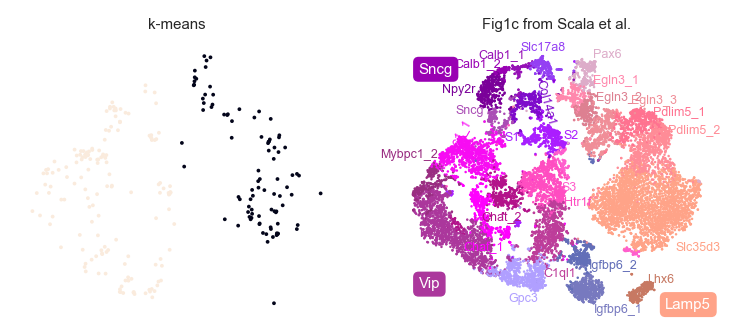

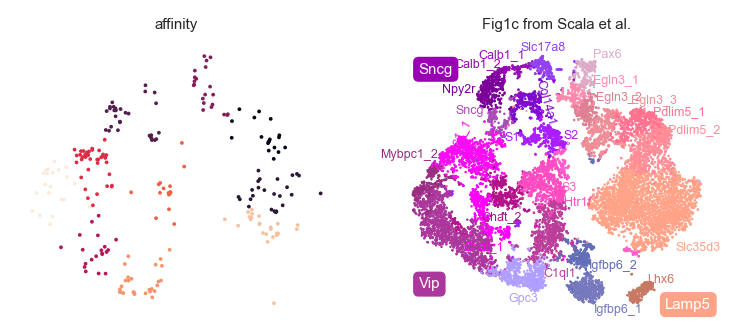

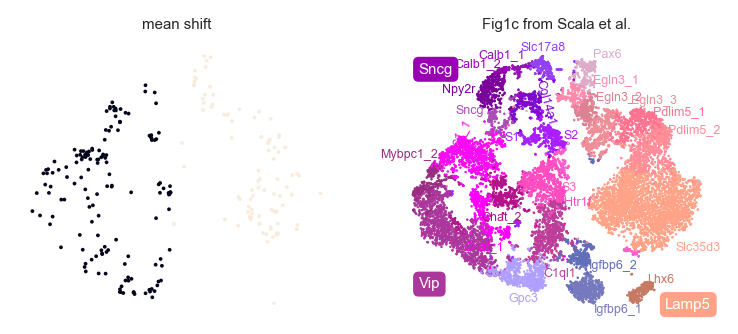

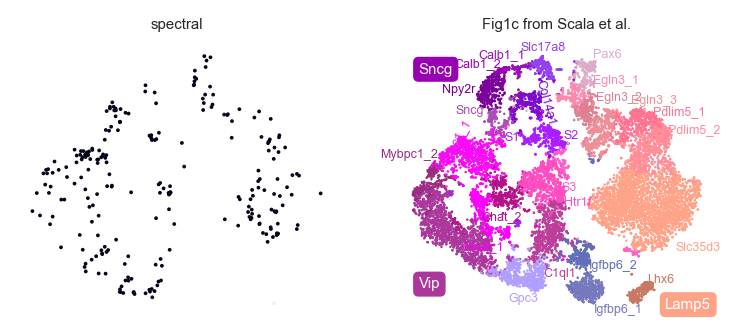

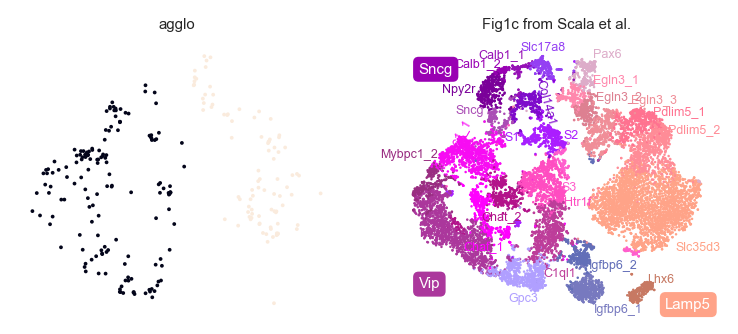

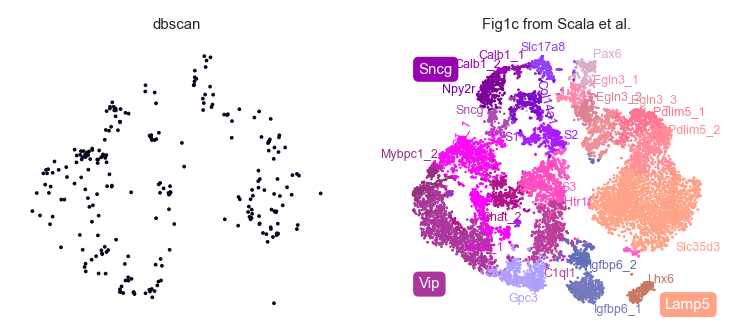

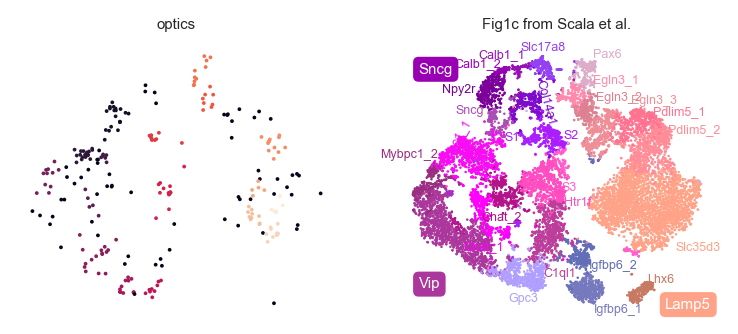

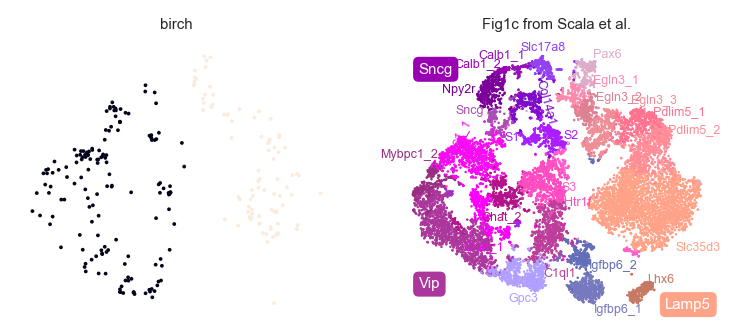

In [15]:
pred_scala, score_scala = print_results(training_data, model_dict_scala,true_labels=scala_family_codes, Z=Z, m1data=m1data)

### Comments

K-means, mean shift, agglomerative,and BIRCH all give very high scores, and the plots show that the Vip and Lamp5 cells are clearly separated (reminder: no Sncg cells for Scala et al.'s dataset). Agglomerative clustering and BIRCH have exceptionally high scores. K-means and mean shift clustering were probably able to score high because the t-SNE clusters are separated into 2 relatively dense clusters with a large gap in between, which are both easy to spot for centroid-based algorithms.

## 2. Smaller transcriptomic types <a class="anchor" id="small"></a>

In [16]:
save = False

### Yao et al.'s cells

There are 27 transcriptomic types for the 15,511 cells. Figure 1c is colored according to these types.

In [17]:
n_clusters = 27 # the number of broad cell families is 3
training_data = Z
file_path = "./models/t-SNE/ttypes/Yao/" # file path to save or load models

In [18]:
yao_ttype_codes = m1data["clusters"]

In [19]:
if save == True:
    model_dict_yao = fit_all_sklearn(training_data=training_data, true_labels=yao_ttype_codes, n_clusters=n_clusters, 
                                 file_path=file_path, random_state=random_state)
else:
    model_dict_yao={}
    model_dict_yao["k-means"] = pickle.load(open(file_path + "k-means" + ".pickle", 'rb'))
    model_dict_yao["affinity"] = pickle.load(open(file_path + "affinity"+".pickle", 'rb'))
    model_dict_yao["mean shift"] = pickle.load(open(file_path + "mean_shift" + ".pickle", 'rb'))
    model_dict_yao["spectral"] = pickle.load(open(file_path + "spectral" + ".pickle", 'rb'))
    model_dict_yao["agglo"] = pickle.load(open(file_path + "agglomerative" + ".pickle", 'rb'))
    model_dict_yao["dbscan"] = pickle.load(open(file_path + "dbscan"+".pickle", 'rb'))
    model_dict_yao["optics"] = pickle.load(open(file_path + "optics" + ".pickle", 'rb'))
    model_dict_yao["birch"] = pickle.load(open(file_path + "birch" + ".pickle", 'rb'))

/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator AffinityPropagation from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SpectralClustering from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/t-r-espr/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator AgglomerativeClustering from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


-------------------------------k-means-------------------------------
Adjusted Mutual Info: 0.7674796688356464
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.5233724800086957
(0: bad, 1: perfect)

-------------------------------affinity-------------------------------
Adjusted Mutual Info: 2.828004149997339e-17
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.27194863296291855
(0: bad, 1: perfect)

-------------------------------mean shift-------------------------------
Adjusted Mutual Info: 0.3176764364917353
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.37085785570442265
(0: bad, 1: perfect)

-------------------------------spectral-------------------------------
Adjusted Mutual Info: 0.7980082115259634
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.7635260989600398
(0: bad, 1: perfect)

-------------------------------agglo-------------------------------
Adjusted Mutual Info: 0.747191339857264
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.4721667478632489
(0: bad, 1: perfect)

---

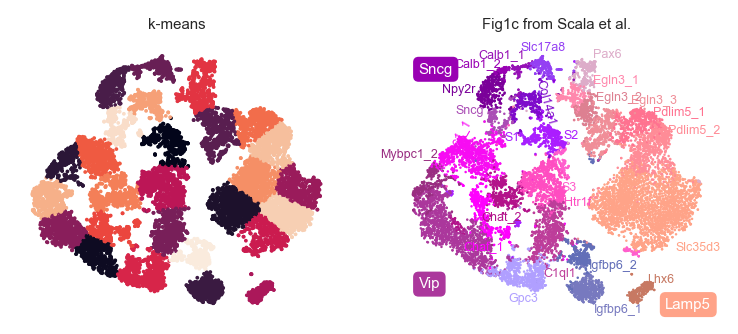

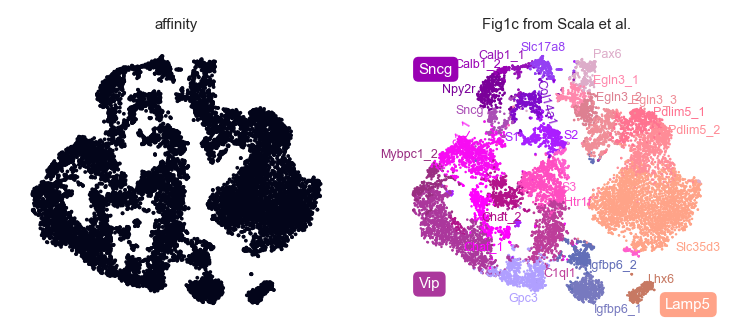

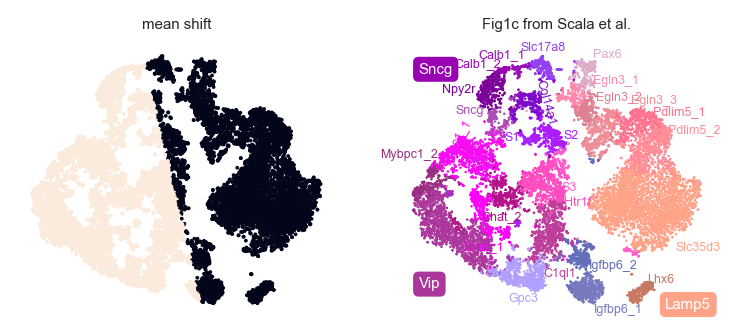

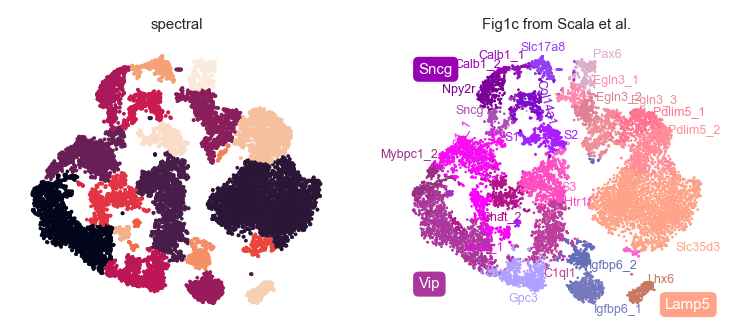

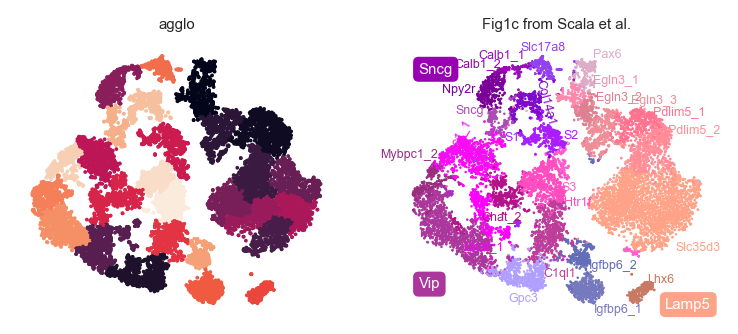

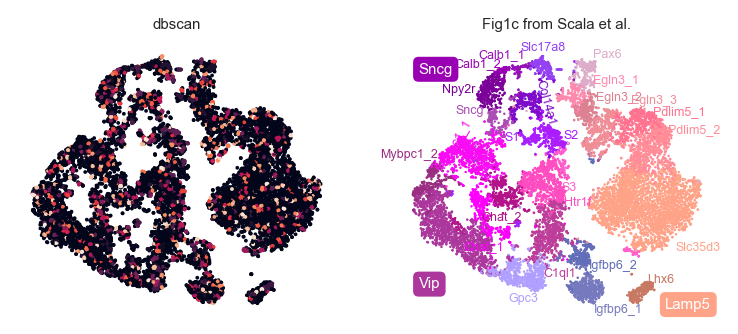

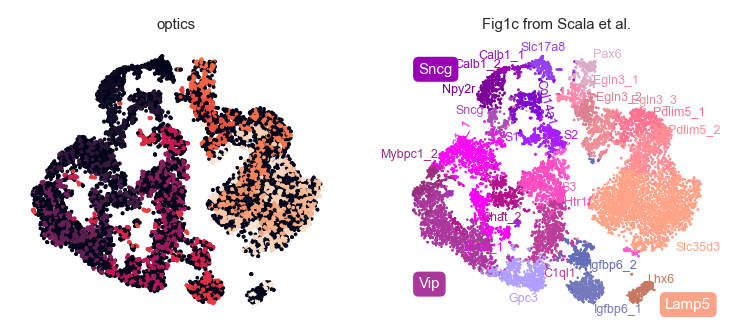

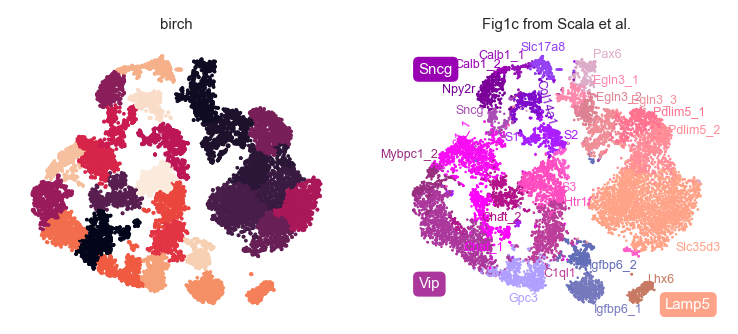

In [20]:
pred_yao, score_yao = print_results(training_data, model_dict_yao,true_labels=yao_ttype_codes, Z=Z, m1data=m1data)

### Comments

Spectral clustering works best for Yao et al.'s data, which means that the graph formed by default parameters best represented the true clusters. Agglomerative clustering and BIRCH did find clusters, but they either over-segmented or put multiple classes in one group, which gave a low Fowlkes-Mallows score.

### Scala et al.'s cells

Scala et al.'s data has 19 transcriptomic types for 244 cells.

In [21]:
n_clusters = 19 # the number of broad cell families is 2
training_data = pos
file_path = "./models/t-SNE/ttypes/Scala/" # file path to save or load models

In [22]:
# get the ttype codes
le = preprocessing.LabelEncoder()
scala_ttype_names = ttypes['type'][subset]
scala_ttype_codes = le.fit_transform(scala_ttype_names)

print("Ttype_labels:")
for label in le.classes_:
    print(f"{label}: {le.transform(np.array(label).reshape(-1,))}")

Ttype_labels:
Lamp5 Egln3_1: [0]
Lamp5 Egln3_2: [1]
Lamp5 Lhx6: [2]
Lamp5 Pax6: [3]
Lamp5 Pdlim5_1: [4]
Lamp5 Pdlim5_2: [5]
Lamp5 Slc35d3: [6]
Vip C1ql1: [7]
Vip Chat_1: [8]
Vip Chat_2: [9]
Vip Gpc3: [10]
Vip Htr1f: [11]
Vip Mybpc1_1: [12]
Vip Mybpc1_2: [13]
Vip Mybpc1_3: [14]
Vip Serpinf1_1: [15]
Vip Serpinf1_2: [16]
Vip Serpinf1_3: [17]
Vip Sncg: [18]


In [23]:
if save == True:
    model_dict_scala = fit_all_sklearn(training_data=pos, true_labels=scala_ttype_codes, n_clusters=n_clusters, 
                                 file_path=file_path, random_state=random_state)
else:
    model_dict_scala={}
    model_dict_scala["k-means"] = pickle.load(open(file_path + "k-means" + ".pickle", 'rb'))
    model_dict_scala["affinity"] = pickle.load(open(file_path + "affinity"+".pickle", 'rb'))
    model_dict_scala["mean shift"] = pickle.load(open(file_path + "mean_shift" + ".pickle", 'rb'))
    model_dict_scala["spectral"] = pickle.load(open(file_path + "spectral" + ".pickle", 'rb'))
    model_dict_scala["agglo"] = pickle.load(open(file_path + "agglomerative" + ".pickle", 'rb'))
    model_dict_scala["dbscan"] = pickle.load(open(file_path + "dbscan"+".pickle", 'rb'))
    model_dict_scala["optics"] = pickle.load(open(file_path + "optics" + ".pickle", 'rb'))
    model_dict_scala["birch"] = pickle.load(open(file_path + "birch" + ".pickle", 'rb'))

-------------------------------k-means-------------------------------
Adjusted Mutual Info: 0.6756140109269919
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.5520595184749825
(0: bad, 1: perfect)

-------------------------------affinity-------------------------------
Adjusted Mutual Info: 0.6600998179682139
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.5717713903928237
(0: bad, 1: perfect)

-------------------------------mean shift-------------------------------
Adjusted Mutual Info: 0.3614665036762038
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.3966618370564028
(0: bad, 1: perfect)

-------------------------------spectral-------------------------------
Adjusted Mutual Info: 0.007623157996404348
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.29240638323814877
(0: bad, 1: perfect)

-------------------------------agglo-------------------------------
Adjusted Mutual Info: 0.6598468462186062
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.5498282941369224
(0: bad, 1: perfect)

----

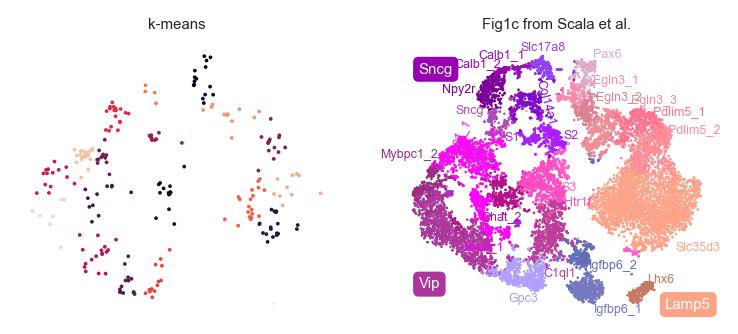

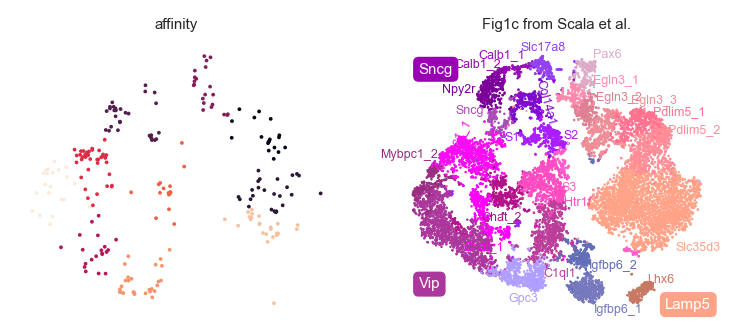

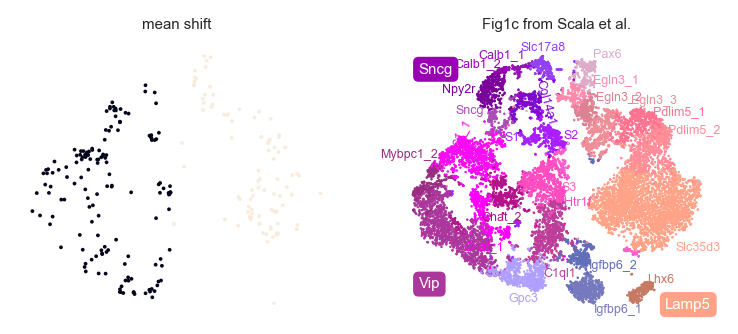

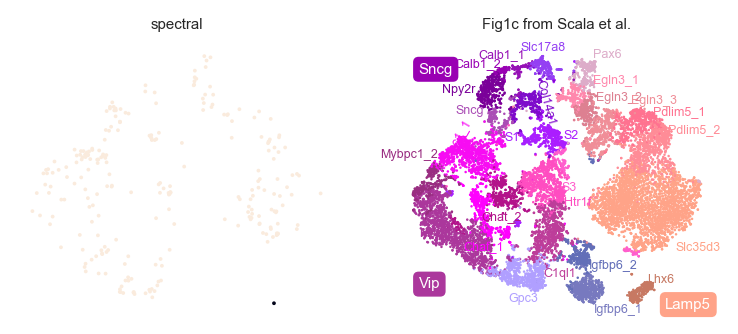

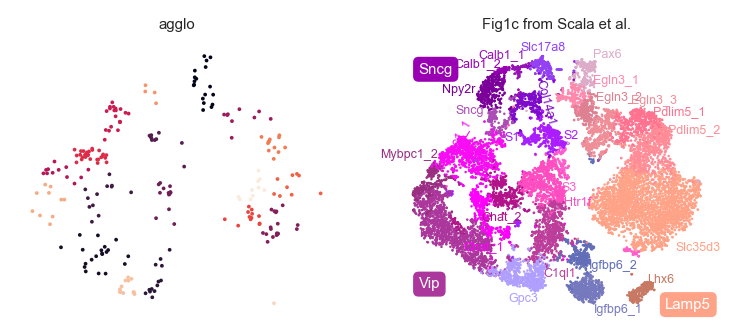

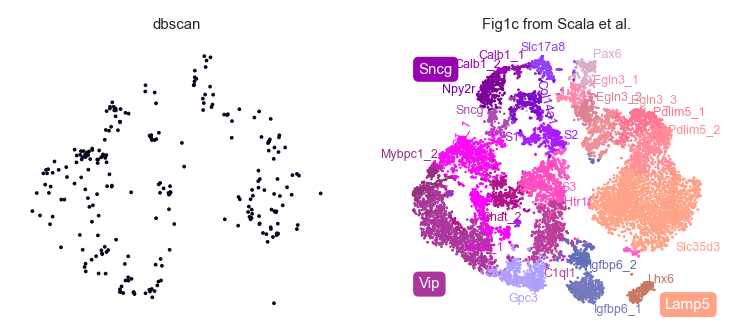

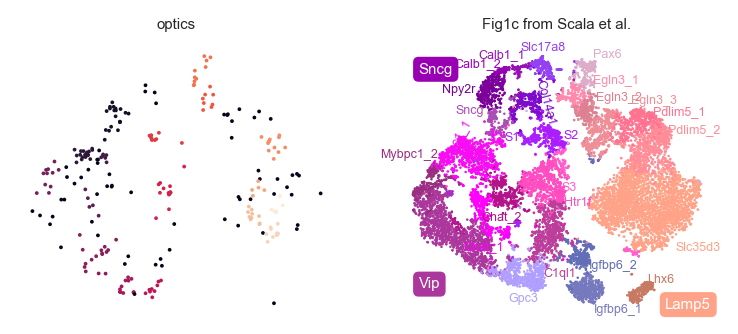

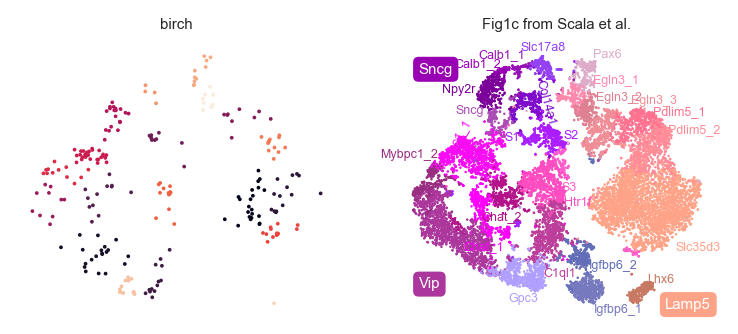

In [24]:
pred_scala, score_scala = print_results(training_data, model_dict_scala,true_labels=scala_ttype_codes, Z=Z, m1data=m1data)

### Comments

Spectral clustering did not give good results for Scala et al.'s cells. This might be because of the small dataset or because Scala et al. used different RNA sequence information (exon/intron counts for Scala et al., UMI counts for Yao et al.). Adjusting the parameters may make a difference. 

Affinity propagation, agglomerative clustering and BIRCH performed relatively well, but not enough to be of interest. My guess is that Scala et al.'s dataset is too small to be clustered into 19 groups.

## Conclusion

For both cell families and cell types, agglomerative clustering and BIRCH consistently gave better results when using the labels assigned in the articles as ground truth. Spectral clustering did give the best result when clustering Yao et al.'s cells into small cell types, but did not show very good performance otherwise. This might be because the clustering with different datasets and different labels requires separate tuning for the graph parameters. 

There is also the slight possibility that the ground truth labels used actually does not reflect reality. The labels were from a large-scale study by Yao et al., where the authors tried to find cell types with RNA sequence and epigenomic data. They concluded that there can be anywhere between ~30 to 116 cell types in the mouse MOp. Scala et al. used the most fine-grained 116 clusters as cell type labels, but if they had used another label assignment in this clustering experiment, the results of this experiment might have been different.